## Figure 2
Laboratory data used for calibration and best fit curves for each model of surface-partitioning by organics. RMSE shown in plot legend.

In [ ]:
import numpy as np
import os
from scipy.optimize import minimize

from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si

from PySDM_examples.Singer_Ward.kappa_mcmc import get_model, param_transform
from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark
from PySDM_examples.Singer_Ward.constants_def import SINGER_CONSTS, plot_colors, plot_lines, plot_names
from PySDM_examples.Singer_Ward.read_mcmc import get_median_mcmc_values

[2.884675e-02 3.474363e-10]  -->  [2.884675e-02 3.474363e-10]
[ 7.6909145e-19 -1.3324160e+01  2.9066210e-02]  -->  [7.69091450e-19 1.63452225e-06 2.90662100e-02]
[ 9.2469330e-19 -1.4102090e+01  1.8666480e-02  3.7380425e+17]  -->  [9.24693300e-19 7.50827429e-07 1.86664800e-02 3.73804250e+17]


<string>:29: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
/Users/claresinger/opt/anaconda3/envs/pysdm/lib/python3.10/site-packages/numba/core/utils.py:612: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",


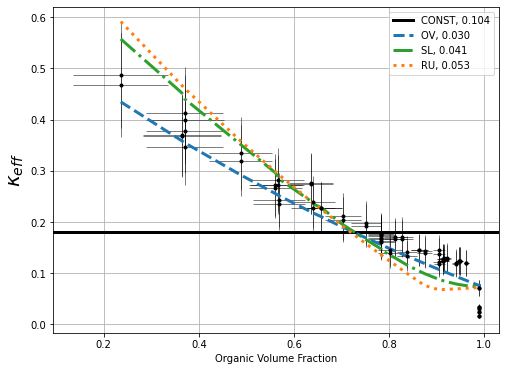

<Figure size 432x288 with 0 Axes>

HTML(value="<a href='./fig2.pdf' target='_blank'>./fig2.pdf</a><br>")

In [1]:
filename = "bcary_dark.csv"
ds = np.loadtxt("data/" + filename, skiprows=1, delimiter=",")
if filename == "bcary_dark.csv":
    ds = np.delete(ds, [26, 65], axis=0)  # remove outliers
r_dry = ds[:, 0] / 2 * 1e-9
ovf = np.minimum(ds[:, 1], 0.99)
d_ovf = ds[:, 2]
kappa_eff = ds[:, 3]
d_kappa_eff = ds[:, 4]
T = 300 * si.K
datay = kappa_eff
errory = d_kappa_eff


FORMULAE = Formulae(constants=SINGER_CONSTS)
WATER_MOLAR_VOLUME = FORMULAE.constants.water_molar_volume
aerosol_list = [AerosolBetaCaryophylleneDark(water_molar_volume=WATER_MOLAR_VOLUME, Forg=ovfi) for ovfi in ovf]
aerosolname = aerosol_list[0].__class__.__name__.split("Aerosol")[-1]


pyplot.figure(figsize=(8,6))
pyplot.errorbar(ovf, datay, yerr=errory, xerr=d_ovf, fmt="k.", lw=0.5)
s = np.argsort(ovf)

for i, model in enumerate(("Constant","CompressedFilmOvadnevaite", "SzyszkowskiLangmuir", "CompressedFilmRuehl")):
    if model == "Constant":
        def f(x):
            return np.sqrt(np.mean((x - datay)**2))
        kap_best_fit = minimize(f, x0=0.5).x[0]
        rmse = np.sqrt(np.mean((kap_best_fit - datay)**2))
        pyplot.axhline(kap_best_fit, color=plot_colors[model], ls=plot_lines[model], lw=3, label=f"{plot_names[model]}, {rmse:.3f}")

    else:
        modelname = model.split("CompressedFilm")[-1]
        args = [T, r_dry, ovf, aerosol_list, model]

        Ntotal, Ncut = 1000, 500
        p_best = get_median_mcmc_values(model, aerosol_list[0], Ntotal, Ncut)

        print(p_best, " --> ", param_transform(p_best, model))
        kap_eff = get_model(p_best, args)
        rmse = np.sqrt(np.mean((kap_eff[s] - datay[s])**2))
        pyplot.plot(ovf[s], kap_eff[s], color=plot_colors[model], ls=plot_lines[model], lw=3, label=f"{plot_names[model]}, {rmse:.3f}")

pyplot.legend()
pyplot.rcParams.update({"font.size":12})
pyplot.xlabel("Organic Volume Fraction")
pyplot.ylabel(r"$\kappa_{eff}$", fontsize=20)
pyplot.grid()
pyplot.show()
show_plot("fig2.pdf")